# **Построение salincy maps: Vanilla gradients and Input x Gradient with Torch**

Добро пожаловать к практической части [курса](https://stepik.org/a/198640), посвященной "ванильным градиентам" (Vanilla Gradients) и Input x Gradient — базовым методам для иобъяснения моделей глубинного обучения.

В [оригинальной статье](https://arxiv.org/pdf/1312.6034), метод Vanilla Gradients предлагается для изображений, поэтому туториал сосредоточен именно на этом типе данных. По определению метода, ничего не мешает применить данный метод для текста, однако практических примеров в статьях и исследованиях мы не нашли.

Приятного кодинга!

In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import requests
import urllib.request
from io import BytesIO
import matplotlib.pyplot as plt

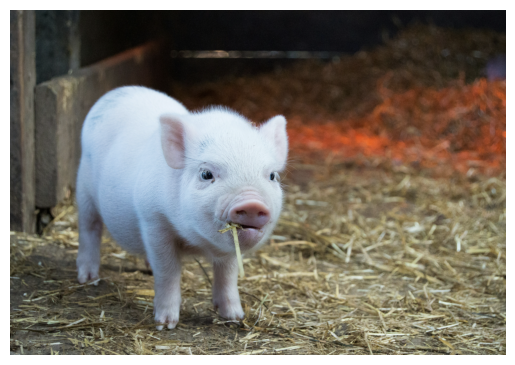

In [2]:
# Загрузка изображения
url = 'https://github.com/aiedu-courses/all_datasets/blob/main/images/pig.png?raw=true'

image_bytes = requests.get(url).content
image = Image.open(BytesIO(image_bytes)) #Рассмотрим конкретный пример x_0

image = image.convert("RGB") #по умолчанию png имеет 4 канала
plt.imshow(image)
plt.axis('off');

Прежде чем работать с изображением, проведем его предобработку (классический шаг). Обратите внимание, что `mean` и `std` мы задаем сразу, не вычисляя. Для моделей, обученных на Imagenet данные значения являются обычной практикой. Они были рассчитаны на основе изображений датасета.

Если вы хотите обучаться с нуля на своем собственном наборе данных, можете рассчитать новое среднее значение и стандартное отклонение. В противном случае рекомендуется использовать предварительно проверенную модель Imagenet с собственным средним и стандартным отклонением.

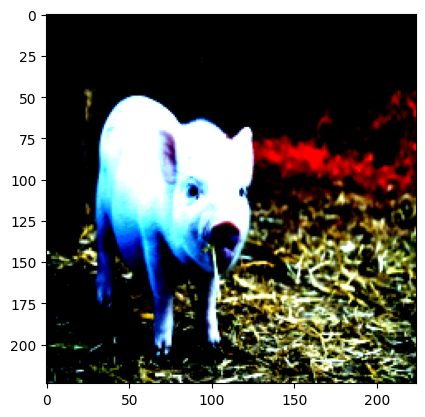

In [3]:
#Средние
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Выполним предобработку изображения
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),          # Преобразование в тензор
    torchvision.transforms.Normalize(mean, std) # Нормализация
])

image = transform(image)

plt.imshow(image.permute((1, 2, 0))); #посмотрим, что получилось после нормализации

После предобработки изображения, для визуализации читаемых saliency maps, хотелось бы получать изображение обратно. Это легко сделать. Вспомним, как работает нормализация.

Пусть $X_{1, 2, 3}$ — изображение, которое подлежит нормализации. Пусть $M_{1, 2, 3}$, $S_{1, 2, 3}$ соответственно средние и стандартные отклонения для каждого канала.

Тогда $X'_i = \frac{(X_{i}-M_{i})}{S_{i}}$.

Откуда $X_i= X'_iS_i+M_i$

Соответственно для обратного образования нам нужно:
-  умножить на стандартное отклонение;
- прибавить средние.

На языке `torch` это будет записано так:


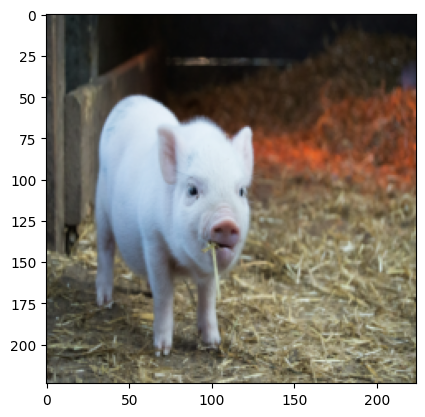

In [4]:
#Функция для выполнения обратного преобразования
invTrans = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                torchvision.transforms.Normalize(mean = [-0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_original = invTrans(image).squeeze()


plt.imshow(inv_original.permute((1, 2, 0)).detach().numpy()); # проверим, что все работает

## **Vanilla backpropagation**

Продолжим работать с преобразованным изображением. Напомню, сейчас оно записано в переменнной `image`.

Пусть мы уже решили задачу. Загрузим обученную модель и подготовим всё для получения прогноза.

In [5]:
model = torchvision.models.densenet201(True); #Загрузим обученную модель
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 71.9MB/s]


In [6]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

**Quiz:** сколько классов способна спрогнозировать модель?

In [7]:
image.unsqueeze_(0);  # добавим размерность батча

image.requires_grad = True  # явно указываем PyTorch рассчитать и сохранить градиенты для входного изображения input_img флагом .requires_grad.

out = model(image)  # делаем forward pass, получаем inference

In [8]:
# Извлечем из прогноза вероятности классов
probabilities = torch.nn.functional.softmax(out, dim=1)

**Quiz** Среди всех классов извлеките класс с наибольшей вероятностью. В ответ укажите спрогнозированную вероятность, округленную до сотых.

In [ ]:
# Среди них извлечем класс, с наибольшей вероятностью

best_id = # Ваш код здесь
best_proba = # Ваш код здесь

print('Спрогнозированная вероятность:', best_proba)
print('Спрогнозированный класс:', categories[best_id])

**Quiz** Извлеките номера и названия топ-3 классов. В ответ укажите название класса с наименьшей вероятностью.

In [ ]:
top_3indicies = # Ваш код здесь
top3_names = # Ваш код здесь

print(top3_names)

In [ ]:
out[0, best_id].backward() # совершим backward pass aka backpropadation
grads = image.grad

## **Построение тепловых карт**

Тепловая карта (она же карта активаций) может быть визуализирована в любой цветовой шкале. В уроке мы обсуждали, как тепловая карта строится в случае трехканального изображения. Мы берем абсолютную максимальную активацию по каждому из каналов и отображаем их на плоскости.

In [ ]:
saliency, _ = torch.max(grads.data.abs(),dim=1) # построим тепловую карту

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 12))


ax[0].imshow(saliency[0], cmap=plt.cm.hot)
ax[0].set_title('Saliency Map for class hog')

ax[1].imshow(inv_original.permute((1, 2, 0)).detach().numpy())
ax[1].set_title('Original Image')

for i in range(0, 2):
  ax[i].axis('off')

plt.show()

Также тепловую карту в некоторых случаях бывает удобнее рассматривать в сером цвете. Для этого нужно сначала восстановить исходные цвета в получаемых градиентах, а затем преобразовать их по [формуле](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert):

$$I_{gray} = I_r*0.2989 + I_g*0.5780 + I_b*0.1140$$

где $R$, $G$, $B$ — красный, зеленый и синий цветовые каналы соответственно.

 То есть, так:

In [ ]:
inv_grads = invTrans(grads).squeeze() # удаляем единичные размерности (в нашем случае это размерность батча)
inv_grads = inv_grads.permute((1, 2, 0)).detach().numpy()

inv_grads_gray = inv_grads[:,:,0] * 0.2989 + inv_grads[:,:,1] * 0.5780 + inv_grads[:,:,2] * 0.1140 # cуммируем значения цветовых каналов с нужными коэффициентами


#Визуализация

plt.imshow(inv_grads_gray, cmap="gray")
plt.title('Grayscale heatmap for class Hog')
plt.axis('off');

Кроме того, в некоторых случаях полезно наложить карту на изображение. Это можно делать математическими преобразованиями — **линейной комбинацией** ихсодных массивов.

**Quiz** Пусть $X, S$ оригинальное изображение и тепловая карта соответственно, $\alpha, \beta$ некоторые изображения. Выберите все варианты, которые являются их линейными комбинациями $X, S$.

In [ ]:
#Оригинальное изображение в сером цвете и наложенная тепловая карта

inv_original = inv_original.permute((1, 2, 0)).detach().numpy() # приводчим трансформированный обратно оригинал в визуализируемый вид

inv_original_gray = inv_original[:,:,0] * 0.2989 + inv_original[:,:,1] * 0.5780 + inv_original[:,:,2] * 0.1140 #преобразуем оригинал к серому цвету

plt.imshow(inv_grads_gray+inv_original_gray, cmap='gray')

In [ ]:
# Не стесняйтесь играть с коэффициентом!
for i in range(1, 10, 2):
  plt.imshow(inv_grads_gray*i+inv_original_gray, cmap='gray')
  plt.title(f'Наложение с коэффициентом {i}')
  plt.show()

In [ ]:
#  Аналогично можно поступить с изображением в цвете

plt.imshow(inv_original/2 + grads.data.squeeze().abs().permute((1, 2, 0)).detach().numpy()*5);
plt.title('Наложение градиентов на оригинальное изображение в цвете')
plt.show()

## Input x Gradient
Перейдемм к следующему изученному методу. По определению из урока, тепловая карта Input x Gradient есть: $$GradientXInput = x\odot \nabla{F_c(x)}$$

Так, для получения такой карты мы можем пойти двумя путями:
1.  воспользоваться готовым методом из библиотеки
2.  построить её на основе Vanilla Gradient

Последовательно посмотрим на оба метода.

## Captum

Captum — библиотека explanable AI для моделей, созданных с использованием PyTorch. Она содержит весь основной набор существующих и используемых методом интерпретации, поэтому на протяжении курса мы будем часто использовать именно её.


> "Captum" на латыни — «понимание».



In [ ]:
!pip install captum -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.0 MB/s eta 0:00:00


In [ ]:
from captum.attr import InputXGradient

input_x_gradient_captum = InputXGradient(model)

attribution = input_x_gradient_captum.attribute(image, target=best_id) # Построение карты

Визуализируем карту inputXgradient по классу с наилучшим id. Напомним, у нас это id 341.

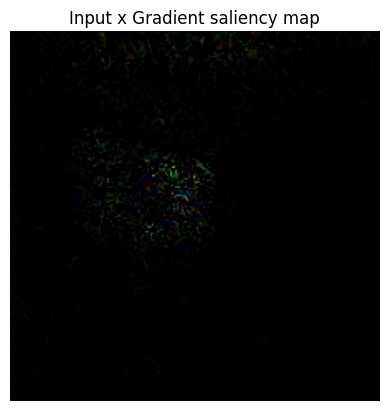

In [ ]:
# Визуализация класса, полученного при помощи InputXGradient из библиотеки

plt.imshow(attribution.squeeze().permute((1, 2, 0)).detach().numpy())
plt.axis('off')

plt.title('Input x Gradient saliency map')
plt.show();

Теперь попробуем обратиться к определению и вычислить карту вручную. Значения, сохраненные как grads у нас отражают матрицу $\nabla{F_c(x)}$.

**Quiz** дополните код, чтобы построить карту по определению. В ответ запишите значение, хранящееся в координате input_x_grad_hand_one[1, 7, 7] (первый канал, седьмая строка, седьмой столбец).

In [ ]:
input_x_grad_hand_one = # Ваш код здесь

plt.imshow(input_x_grad_hand_one.permute(1, 2, 0).detach().numpy())

In [ ]:
input_x_grad_hand_one[1, 7, 7]

**Quiz** Покоординатно сравните значения в  координатах `attribution` и `input_x_grad_hand_one`. Равны ли они?

In [ ]:
# Ваш код здесь

tensor(150528)

# **Дополнительные материалы**:
- [Туториал](https://www.coderskitchen.com/explainable-ai-how-to-implement-saliency-maps/) по созданию saliency maps, если вы работаете с tensorflow